In [8]:
import numpy as np 
import pandas as pd
df=pd.read_csv('housing_dataset.txt',
    header=None,
    sep=',')
df.columns=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


C:\Users\jb5nn\anaconda3\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


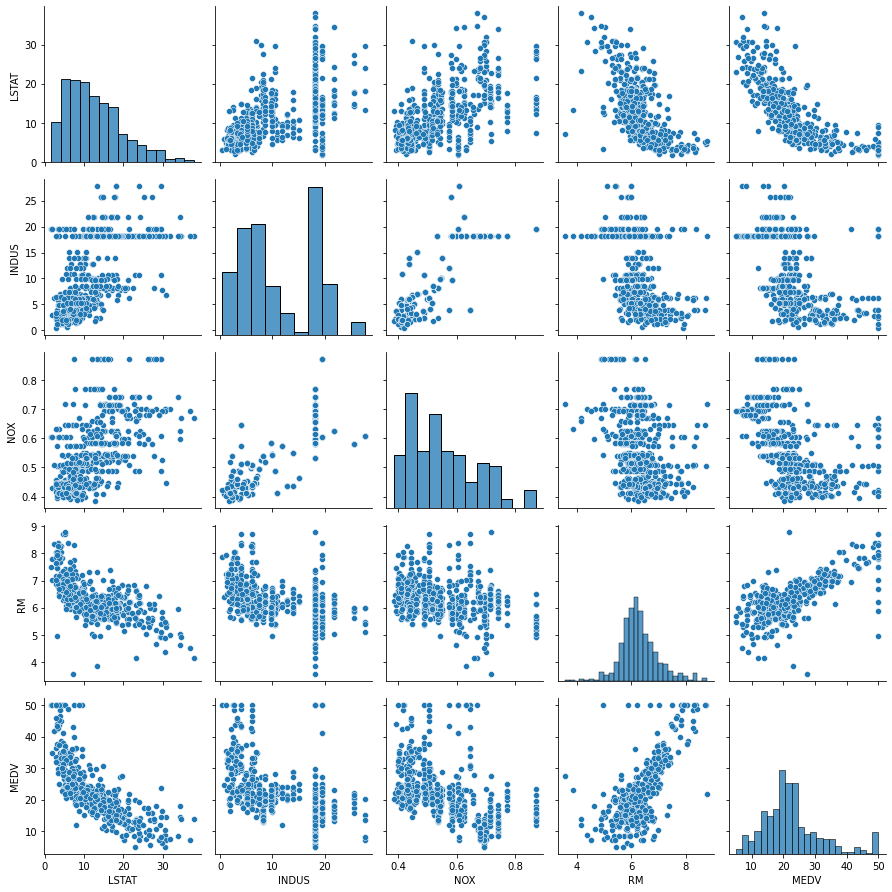

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], size =2.5)
plt.tight_layout()
plt.show()


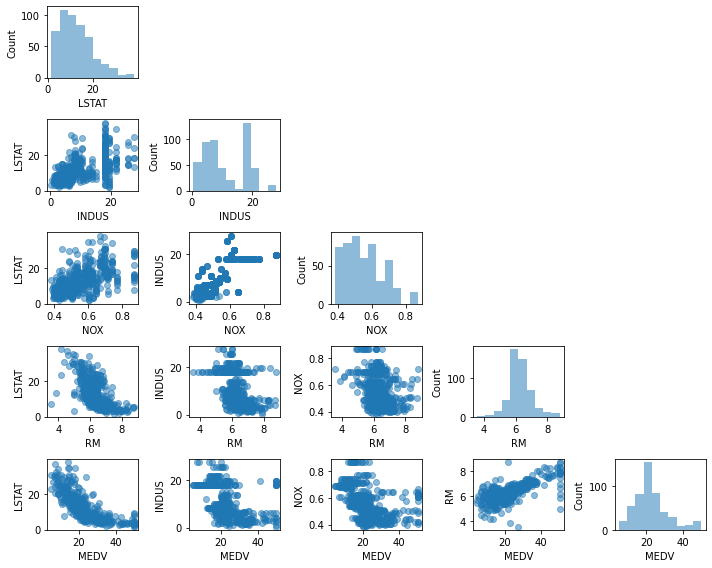

In [10]:
from mlxtend.plotting import scatterplotmatrix
scatterplotmatrix(df[cols].values, 
    figsize=(10,8),
    names=cols,
    alpha=0.5)
plt.tight_layout()
plt.show()

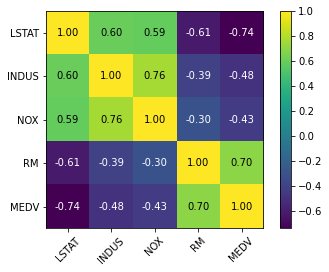

In [11]:
from mlxtend.plotting import heatmap
cm = np.corrcoef(df[cols].values.T)
hm=heatmap(cm,
	row_names=cols,
	column_names=cols)
plt.show()


Implementazione manuale

In [12]:
class LinearRegressionGD(object):
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    def predict(self, X):
        return self.net_input(X)


Faccio una regressione usando solo due delle feature con miglior correlazione lineare

In [13]:
X=df[['RM']].values
y=df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_x=StandardScaler()
sc_y=StandardScaler()
X_std=sc_x.fit_transform(X)
y_std=sc_y.fit_transform(y[:,np.newaxis]).flatten()
lr=LinearRegressionGD()
lr.fit(X_std, y_std)


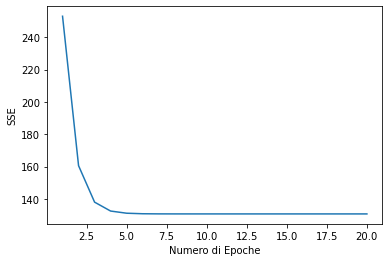

In [15]:
# Credo di star facendo un plot della funzione costo epoca per epoca
plt.plot(range(1,lr.n_iter+1),lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Numero di Epoche')
plt.show()


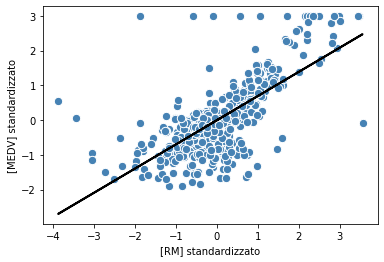

In [16]:
def lin_regplot(X,y, model):
    plt.scatter(X,
        y,
        c='steelblue',
        edgecolor='white',
        s=70)
    plt.plot(X,
        model.predict(X),
        color='black',
        lw=2)
    return None
lin_regplot(X_std,
    y_std,
    lr)
plt.xlabel('[RM] standardizzato')
plt.ylabel('[MEDV] standardizzato')
plt.show()

In [17]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print('Prezzo in $1000s: %.3f' %sc_y.inverse_transform(price_std))

Prezzo in $1000s: 10.840


Ok ora lo faccio con sklearnmerda YEEEEEEEEEEEE

In [18]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X,y)
y_pred = slr.predict(X)
print('Pendenza: %.3f' % slr.coef_[0])
print('Intercetta: %.3f' % slr.intercept_)

Pendenza: 9.102
Intercetta: -34.671


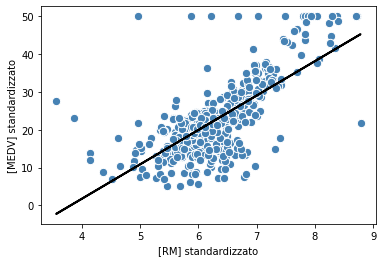

In [19]:
lin_regplot(X,
    y,
    slr)
plt.xlabel('[RM] standardizzato')
plt.ylabel('[MEDV] standardizzato')
plt.show()

Ok ora mi concetro sul RANSACRegressor e vediamo come variano i risultati evitando di prendere anche i dati a fanculo lontanissimo

In [20]:
from sklearn.linear_model import RANSACRegressor
ransac= RANSACRegressor(LinearRegression(),
            max_trials=100,
            min_samples=50,
            loss='absolute_loss',
            residual_threshold=5.0,
            random_state=0)
ransac.fit(X,y)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=50,
                random_state=0, residual_threshold=5.0)

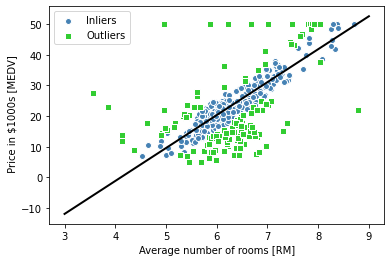

In [25]:
inlier_mask_ = ransac.inlier_mask_
outlier_mask_ = np.logical_not(inlier_mask_)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:,np.newaxis])

plt.scatter(X[inlier_mask_], 
    y[inlier_mask_],
    c='steelblue',
    edgecolor='white',
    marker='o', 
    label ='Inliers')
    
plt.scatter(X[outlier_mask_], 
    y[outlier_mask_],
    c='limegreen', 
    edgecolor='white',
    marker='s', 
    label='Outliers')

plt.plot(line_X, 
    line_y_ransac, 
    color ='black', 
    lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel(' Price in $1000s [MEDV]')
plt.legend(loc='upper left' )
plt.show()


Valutazione delle performance del modello

In [26]:
from sklearn.model_selection import train_test_split
X=df.iloc[:,:-1].values
y=df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr=LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

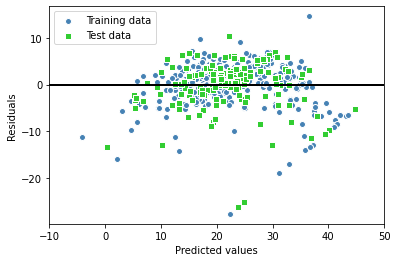

In [27]:
plt.scatter(y_train_pred, 
    y_train_pred - y_train,
    c='steelblue',
    marker='o',
    edgecolor='white',
    label ='Training data')
plt.scatter( y_test_pred, 
    y_test_pred - y_test, 
    c='limegreen', 
    marker='s', 
    edgecolor='white',
    label ='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.show()


Prova Mean Squared Error

In [28]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test : %.3f' % (mean_squared_error(y_train, y_train_pred ) ,
 mean_squared_error( y_test , y_test_pred )))


MSE train: 19.958, test : 27.196


In [29]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train,y_train_pred), r2_score(y_test, y_test_pred)))

R^2 train: 0.765, test: 0.673
